 ##  0. Importing Packages

In [12]:
%run import_modules.py 
import warnings
import time
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)


import matplotlib.pylab as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#tf.logging.set_verbosity(tf.logging.ERROR)
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#from tensorflow import set_random_seed         ##tf.random.set_seed(1)
import keras 
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.callbacks import EarlyStopping

from scipy.stats.mstats import gmean

In [2]:
cd C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\5차\Data

C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\5차\Data


## 1. Reading Data

In [4]:
myseed = 56 #anchoring

df_train = pd.read_csv('X_train.csv', encoding='cp949') #F5
df_test = pd.read_csv('X_test.csv', encoding='cp949')
f_data = pd.concat([df_train, df_test]).reset_index(drop=True)

y_train = pd.read_csv('y_train.csv').gender # y_train
IDtest = pd.read_csv('X_test.csv', encoding='cp949').cust_id.unique() #target ID for prediction

## 2. Feature Generation (Word2Vec) by 김세홍

In [5]:
# * W2V을 이용한 feature 이용하여 생성(min,max,mean,sum,std)
# * train과 test 데이터를 합하여 W2V 학습

### Make corpus
p_level = 'gds_grp_nm'  # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 n배 oversampling을 수행
def oversample(x, n, seed=0):
    if n == 0:
        return list(x)
    uw = np.unique(x)
    bs = np.array([])
    np.random.seed(seed)
    for j in range(n):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    return list(bs)

X_train = list(df_train.groupby('cust_id')[p_level].agg(oversample, 20))
X_test = list(df_test.groupby('cust_id')[p_level].agg(oversample, 20))
F_data = list(f_data.groupby('cust_id')[p_level].agg(oversample,20))

### Training the Word2Vec model
num_features = 100 # 단어 벡터 차원 수
min_word_count = 1 # 최소 단어 수
context = 5 # 학습 윈도우(인접한 단어 리스트) 크기

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
w2v = word2vec.Word2Vec(F_data, 
                        size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        seed=myseed, workers=6, sg=0)
# 필요없는 메모리 unload
w2v.init_sims(replace=True)

In [6]:
vocabs = w2v.wv.vocab.keys()
vocab_vectors_list = [w2v.wv[v] for v in vocabs]
word_embeddings = pd.DataFrame(w2v.wv.syn0norm[:, :], index=w2v.wv.index2word[:])
word_embeddings

F = f_data[['cust_id','gds_grp_nm']]

train_test = pd.merge(left = F, right = word_embeddings, left_on='gds_grp_nm', right_index=True,how='left')
train_test = train_test.drop(['gds_grp_nm'], axis=1)

m = pd.DataFrame(train_test['cust_id'].unique())
m.rename(columns={0:'cust_id'},inplace=True)
for i in range(100) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.min',np.min)]).reset_index()
    m = pd.merge(left = m,right = s,on='cust_id',how='outer')

mx = pd.DataFrame(train_test['cust_id'].unique())
mx.rename(columns={0:'cust_id'},inplace=True)
for i in range(100) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.max',np.max)]).reset_index()
    mx = pd.merge(left = mx,right = s,on='cust_id',how='outer')

mn = pd.DataFrame(train_test['cust_id'].unique())
mn.rename(columns={0:'cust_id'},inplace=True)
for i in range(100) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.mean',np.mean)]).reset_index()
    mn = pd.merge(left = mn,right = s,on='cust_id',how='outer')

ss = pd.DataFrame(train_test['cust_id'].unique())
ss.rename(columns={0:'cust_id'},inplace=True)
for i in range(100) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.sum',np.sum)]).reset_index()
    ss = pd.merge(left = ss,right = s,on='cust_id',how='outer')

st = pd.DataFrame(train_test['cust_id'].unique())
st.rename(columns={0:'cust_id'},inplace=True)
for i in range(100) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.std',np.std)]).reset_index()
    st = pd.merge(left = st,right = s,on='cust_id',how='outer')
st = st.fillna(0)

#Merge
train_test = pd.merge(m,mx, on='cust_id', how='outer')
train_test = pd.merge(train_test,mn, on='cust_id', how='outer')
train_test = pd.merge(train_test,ss, on ='cust_id', how='outer')
train_test = pd.merge(train_test,st, on = 'cust_id', how='outer')


### 3. Data Preprocessing - Feature Engineering

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)

X_train.shape, X_test.shape

((3500, 500), (2482, 500))

## 3. Build Models

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Model: "model_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
dense_236 (Dense)               (None, 128)          64128       input_44[0][0]                   
__________________________________________________________________________________________________
dropout_97 (Dropout)            (None, 128)          0           dense_236[0][0]                  
__________________________________________________________________________________________________
dense_237 (Dense)               (None, 128)          16512       dropout_97[0][0]                 
___________________________________________________________________________________________

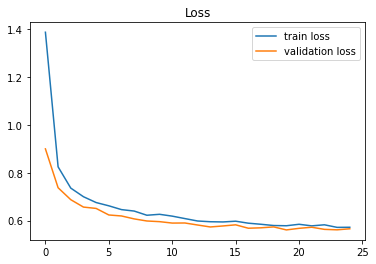

 10%|████████▎                                                                          | 1/10 [00:05<00:53,  5.96s/it]

AUC 0.7827070932539683
Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
dense_241 (Dense)               (None, 128)          64128       input_45[0][0]                   
__________________________________________________________________________________________________
dropout_99 (Dropout)            (None, 128)          0           dense_241[0][0]                  
__________________________________________________________________________________________________
dense_242 (Dense)               (None, 128)          16512       dropout_99[0][0]                 
____________________________________________________________________

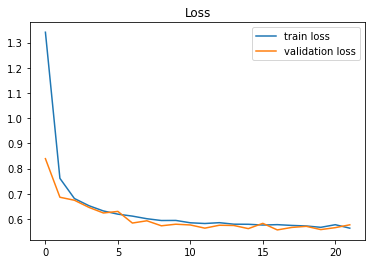

AUC 0.7721538782318599


 20%|████████████████▌                                                                  | 2/10 [00:11<00:45,  5.72s/it]

Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
dense_246 (Dense)               (None, 128)          64128       input_46[0][0]                   
__________________________________________________________________________________________________
dropout_101 (Dropout)           (None, 128)          0           dense_246[0][0]                  
__________________________________________________________________________________________________
dense_247 (Dense)               (None, 128)          16512       dropout_101[0][0]                
___________________________________________________________________________________________

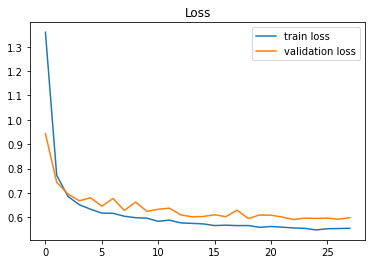

 30%|████████████████████████▉                                                          | 3/10 [00:17<00:40,  5.78s/it]

AUC 0.7522510833744194
Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
dense_251 (Dense)               (None, 128)          64128       input_47[0][0]                   
__________________________________________________________________________________________________
dropout_103 (Dropout)           (None, 128)          0           dense_251[0][0]                  
__________________________________________________________________________________________________
dense_252 (Dense)               (None, 128)          16512       dropout_103[0][0]                
____________________________________________________________________

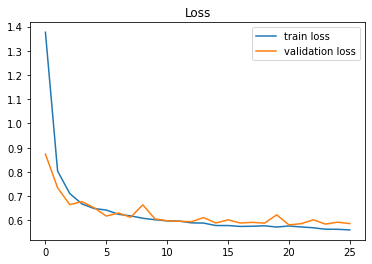

 40%|█████████████████████████████████▏                                                 | 4/10 [00:22<00:34,  5.73s/it]

AUC 0.7756368734416453
Model: "model_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
dense_256 (Dense)               (None, 128)          64128       input_48[0][0]                   
__________________________________________________________________________________________________
dropout_105 (Dropout)           (None, 128)          0           dense_256[0][0]                  
__________________________________________________________________________________________________
dense_257 (Dense)               (None, 128)          16512       dropout_105[0][0]                
____________________________________________________________________

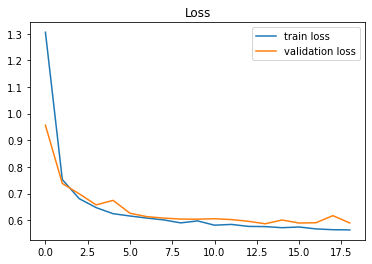

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:27<00:27,  5.59s/it]

AUC 0.7595236013986015
Model: "model_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
dense_261 (Dense)               (None, 128)          64128       input_49[0][0]                   
__________________________________________________________________________________________________
dropout_107 (Dropout)           (None, 128)          0           dense_261[0][0]                  
__________________________________________________________________________________________________
dense_262 (Dense)               (None, 128)          16512       dropout_107[0][0]                
____________________________________________________________________

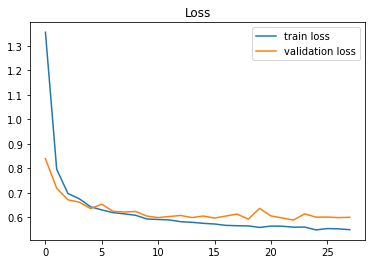

AUC 0.7461070720423002


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:34<00:23,  5.75s/it]

Model: "model_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
dense_266 (Dense)               (None, 128)          64128       input_50[0][0]                   
__________________________________________________________________________________________________
dropout_109 (Dropout)           (None, 128)          0           dense_266[0][0]                  
__________________________________________________________________________________________________
dense_267 (Dense)               (None, 128)          16512       dropout_109[0][0]                
___________________________________________________________________________________________

2800/2800 [==============================] - 0s 50us/step - loss: 0.5598 - acc: 0.7425 - auc_49: 0.7630 - val_loss: 0.5472 - val_acc: 0.7529 - val_auc_49: 0.7636
Epoch 32/1000
2800/2800 [==============================] - 0s 50us/step - loss: 0.5606 - acc: 0.7314 - auc_49: 0.7640 - val_loss: 0.5657 - val_acc: 0.7629 - val_auc_49: 0.7643
Epoch 33/1000
2800/2800 [==============================] - 0s 51us/step - loss: 0.5598 - acc: 0.7293 - auc_49: 0.7647 - val_loss: 0.5516 - val_acc: 0.7600 - val_auc_49: 0.7650
Epoch 34/1000
2800/2800 [==============================] - 0s 50us/step - loss: 0.5623 - acc: 0.7321 - auc_49: 0.7654 - val_loss: 0.5469 - val_acc: 0.7643 - val_auc_49: 0.7656
Epoch 35/1000
2800/2800 [==============================] - 0s 48us/step - loss: 0.5565 - acc: 0.7400 - auc_49: 0.7659 - val_loss: 0.5573 - val_acc: 0.7500 - val_auc_49: 0.7664
Epoch 36/1000
2800/2800 [==============================] - 0s 51us/step - loss: 0.5597 - acc: 0.7264 - auc_49: 0.7667 - val_loss: 0.55

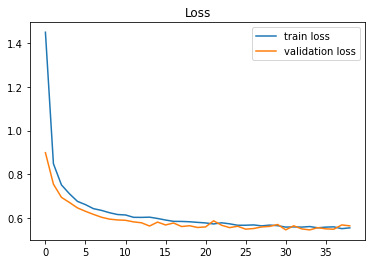

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:41<00:19,  6.37s/it]

AUC 0.7860456347118454
Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
dense_271 (Dense)               (None, 128)          64128       input_51[0][0]                   
__________________________________________________________________________________________________
dropout_111 (Dropout)           (None, 128)          0           dense_271[0][0]                  
__________________________________________________________________________________________________
dense_272 (Dense)               (None, 128)          16512       dropout_111[0][0]                
____________________________________________________________________

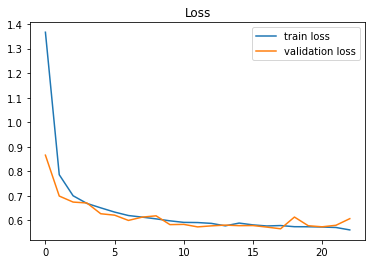

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:47<00:12,  6.06s/it]

AUC 0.7592616619525824
Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
dense_276 (Dense)               (None, 128)          64128       input_52[0][0]                   
__________________________________________________________________________________________________
dropout_113 (Dropout)           (None, 128)          0           dense_276[0][0]                  
__________________________________________________________________________________________________
dense_277 (Dense)               (None, 128)          16512       dropout_113[0][0]                
____________________________________________________________________

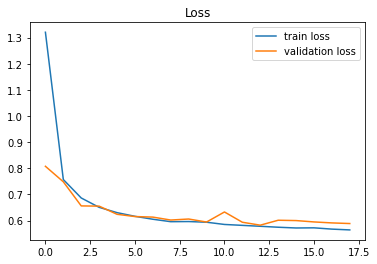

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:51<00:05,  5.61s/it]

AUC 0.762330201295045
Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
dense_281 (Dense)               (None, 128)          64128       input_53[0][0]                   
__________________________________________________________________________________________________
dropout_115 (Dropout)           (None, 128)          0           dense_281[0][0]                  
__________________________________________________________________________________________________
dense_282 (Dense)               (None, 128)          16512       dropout_115[0][0]                
_____________________________________________________________________

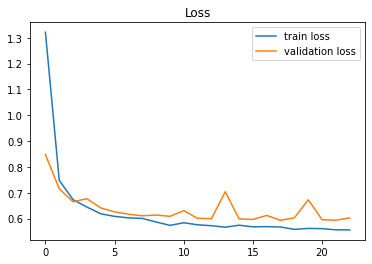

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.77s/it]

AUC 0.7385672643606577

Validation Summary:
6    0.786046
0    0.782707
3    0.775637
1    0.772154
8    0.762330
4    0.759524
7    0.759262
2    0.752251
5    0.746107
9    0.738567
dtype: float64
mean=0.76346, std=0.016


In [18]:
# Define the number of features
max_features = X_train.shape[1]

# Define the Model architecture
N = 10
p = 3.5
preds = []
aucs = []

for i in tqdm(range(N)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)

    # Define the Model architecture
    input = Input(shape=(X_train.shape[1],)) 
    x = Dense(128, activation='elu', input_shape=(max_features,), kernel_regularizer='l2', kernel_initializer='he_normal')(input) 
    x = Dropout(0.1)(x)
    x1 = Dense(128)(x)
    x = Add()([x1, x])
    x = Dense(16, activation='elu', kernel_initializer='he_normal')(x)
    x = Dropout(0.1)(x)
    x1 = Dense(16)(x)
    x = Add()([x1, x])
    #x = PReLU()(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    model.summary()

    # Train the Model
    model.compile(optimizer='Adagrad', loss='binary_crossentropy', metrics=['acc',tf.keras.metrics.AUC()])

    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2)

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=5),
                 keras.callbacks.ModelCheckpoint(filepath='best_model4.h5',
                                                 monitor='val_loss',
                                                 save_best_only=True)]

    history = model.fit(train_x, train_y, epochs=1000, batch_size=64, 
                        validation_data=(valid_x, valid_y), callbacks=callbacks)

    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()
    
    auc = roc_auc_score(valid_y, model.predict(valid_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())

print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))

In [20]:
cd C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\5차\Submission

C:\Users\john9\Downloads\3학년 2학기\머신러닝\과제\5차\Submission


In [21]:
from scipy.stats.mstats import gmean
# Power mean ensemble
THRESHOLD = 0.775 # Use only models whose AUC exceeds this value

target_pred = []
n = 0
for i in range(N):
    if aucs.iloc[i] > THRESHOLD:
        target_pred.append(preds[i])
        n += 1
pred = gmean(target_pred)

# Make a submission file
t = pd.Timestamp.now()
fname = f"DNN_F5_En{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'DNN_F5_En3_submit_06151815.csv' is ready to submit.
